## Test `NetworkModel`

In [1]:
import numpy as np
from coremdlr.models import NetworkModel
from coremdlr.datasets import DepthSequenceGenerator, FaciesDataset

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [11]:
fdset = FaciesDataset(["205-21b-3", "204-20-6a", "204-24a-6","204-20-1Z"],
                    test_wells=["204-19-6"],
                    features=["pseudoGR"],
                    label_resolution=32)

In [12]:
fdset.load_or_generate_data()

Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (3842,)), ('pseudoGR', (3842, 32))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (3872,)), ('pseudoGR', (3872, 32))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (13012,)), ('pseudoGR', (13012, 32))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (2341,)), ('pseudoGR', (2341, 32))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (1884,)), ('pseudoGR', (1884, 32))]


In [4]:
print(np.bincount(fdset.y_train) / fdset.y_train.size)
print(np.bincount(fdset.y_test) / fdset.y_test.size)

[0.30602869 0.16348113 0.23837386 0.29211633]
[0.49575372 0.16295117 0.15127389 0.19002123]


In [9]:
bcnn_model_args = {
    'feature' : 'image',
    'network' : 'bilinear_cnn',
    'sequence_size' : 12,
    'network_args' : {
        'conv1x1' : 32,
        'backbone_cnn' : 'vgg16',
        'lstm_features' : None,
        'dropout_rate' : 0.25,
        'apply_rowwise' : True
    },
    'optimizer_args' : {
        'optimizer' : 'Adam',
        'clipnorm' : 10.
    },
    'loss' : {'ordinal_squared_error': 0.5,
              'categorical_crossentropy': 1.0}
}

bcnn_model = NetworkModel(fdset, model_args=bcnn_model_args)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 384, 600, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 12, 18, 512)  14714688    input_6[0][0]                    
__________________________________________________________________________________________________
reduce_A (Conv2D)               (None, 12, 18, 32)   16416       vgg16[1][0]                      
__________________________________________________________________________________________________
reduce_B (Conv2D)               (None, 12, 18, 32)   16416       vgg16[1][0]                      
__________________________________________________________________________________________________
unstack_ro

In [10]:
fit_args = {
    'batch_size' : 4,
    'step_size' : bcnn_model.sequence_size - 2,
    'epochs' : 10,
}

bcnn_model.fit(fdset, **fit_args)

Shapes of `(batch_X, batch_y)`: (4, 384, 600, 3), (4, 12, 4)
Epoch 1/10
576/576 [==============================] - 186s 324ms/step - loss: 1.7936 - acc: 0.5336 - val_loss: 2.5477 - val_acc: 0.4978
Epoch 2/10
576/576 [==============================] - 187s 325ms/step - loss: 2.1508 - acc: 0.2919 - val_loss: 2.1207 - val_acc: 0.4978
Epoch 3/10
575/576 [============================>.] - ETA: 0s - loss: nan - acc: 0.3129

Exception in thread Thread-36:
Traceback (most recent call last):
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/tensorflow/python/keras/utils/data_utils.py", line 577, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/tensorflow/python/keras/utils/data_utils.py", line 551, in <lambda>
    workers, initializer=init_pool, initargs=(seqs,))
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/multiprocessing/context.py", line 119, in Pool
    context=self.get_context())
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/multiprocessing/pool.py", line 174, in _

576/576 [==============================] - 157s 272ms/step - loss: nan - acc: 0.3129 - val_loss: nan - val_acc: 0.4978
Epoch 4/10


KeyboardInterrupt: 

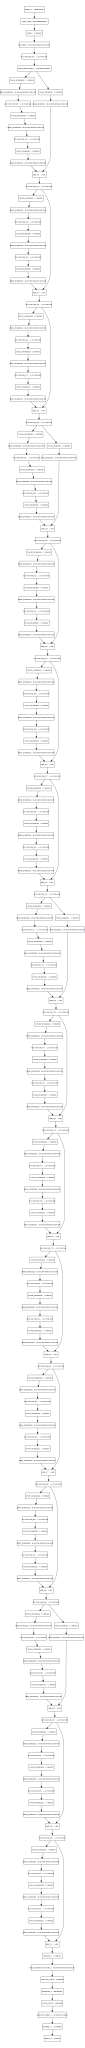

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(deepten_model.network).create(prog='dot', format='svg'))

In [4]:
strip = fdset.wells[0]._make_striplog()

In [21]:
import pandas as pd
from io import StringIO

pd.read_csv(StringIO(strip.to_csv()))

,Top,Base,Component
0,1812.002014,1812.023494,"None, n"
1,1812.023494,1812.270515,"Sandy mudstone, y"
2,1812.270515,1812.372546,"Sandstone, n"
3,1812.372546,1812.909549,"Sandy mudstone, y"
4,1812.909549,1813.048878,"None, n"
5,1813.048878,1813.348845,"Sandy mudstone, y"
6,1813.348845,1813.364915,"None, n"
7,1813.364915,1813.670238,"Sandy mudstone, y"
8,1813.670238,1813.702377,"Sandstone, y"
9,1813.702377,1813.991630,"Sandy mudstone, y"


In [24]:
from striplog import Decor, Component, Legend

###++++++++++++++++++++###
### Facies Definitions ###
###++++++++++++++++++++###

facies = {
    'nc': Component({'lithology': 'none', 'train':'n'}),
    'bs': Component({'lithology': 'sandstone', 'train': 'n'}),
    's': Component({'lithology': 'sandstone', 'train':'y'}),
    'is': Component({'lithology': 'clay-prone sandstone', 'train':'y'}),
    'ih': Component({'lithology': 'sandy mudstone', 'train':'y'}),
    'sh': Component({'lithology': 'mudstone', 'train':'y'}),
    't': Component({'lithology': 'turbidite', 'train':'y'}),
}

lithologies = [c.lithology for c in facies.values()]

def lithology_to_key(lithology_str):
    try:
        litho = lithology_str.split(',')[0].lower()
        idx = lithologies.index(litho)
        return list(facies.keys())[idx]
    except IndexError:
        raise ValueError('{} is not present in lithologies: {}'.format(lithology_str, lithologies))

In [26]:
df = pd.read_csv(StringIO(strip.to_csv()))
df.Component = df.Component.apply(lithology_to_key)
df

,Top,Base,Component
0,1812.002014,1812.023494,nc
1,1812.023494,1812.270515,ih
2,1812.270515,1812.372546,bs
3,1812.372546,1812.909549,ih
4,1812.909549,1813.048878,nc
5,1813.048878,1813.348845,ih
6,1813.348845,1813.364915,nc
7,1813.364915,1813.670238,ih
8,1813.670238,1813.702377,bs
9,1813.702377,1813.991630,ih


In [28]:
df.columns = ['top', 'base', 'lithology']
df.to_csv()

,top,base,lithology
0,1812.002014,1812.023494,nc
1,1812.023494,1812.270515,ih
2,1812.270515,1812.372546,bs
3,1812.372546,1812.909549,ih
4,1812.909549,1813.048878,nc
5,1813.048878,1813.348845,ih
6,1813.348845,1813.364915,nc
7,1813.364915,1813.670238,ih
8,1813.670238,1813.702377,bs
9,1813.702377,1813.991630,ih


In [7]:
from coremdlr.datasets import strip_config

In [17]:
list(strip_config.values())[0].lithology

'none'

In [14]:
fdset.wells[0]._y.size

5032

In [14]:
fdset.wells[0]._image.max()

255.0

In [17]:
fdset.wells[0].data_path

PosixPath('/home/administrator/Dropbox/core_data/facies/train_data')

In [18]:
img = np.load('/home/administrator/Dropbox/core_data/facies/train_data/204-19-6_image.npy')
img.min(), img.max()

(0, 255)

In [23]:
a = np.random.rand(10,5)
a

array([[0.95964232, 0.78682589, 0.653123  , 0.03316587, 0.74450348],
       [0.90587012, 0.66222696, 0.74504095, 0.87253328, 0.30188441],
       [0.27823403, 0.10322789, 0.56228874, 0.23668918, 0.97020282],
       [0.04541525, 0.98712989, 0.35855614, 0.96409874, 0.41059792],
       [0.31086048, 0.25875895, 0.56398877, 0.65157662, 0.1385309 ],
       [0.90979053, 0.01251038, 0.33475246, 0.28956825, 0.37394684],
       [0.49419519, 0.23966382, 0.32036806, 0.91414811, 0.68752542],
       [0.56787169, 0.13439816, 0.12010493, 0.95375132, 0.25044923],
       [0.62658311, 0.60035919, 0.84875429, 0.67767033, 0.11330061],
       [0.07838619, 0.35789408, 0.35474469, 0.01106552, 0.27389968]])

In [25]:
a[np.where(a > 0.5)]

array([0.95964232, 0.78682589, 0.653123  , 0.74450348, 0.90587012,
       0.66222696, 0.74504095, 0.87253328, 0.56228874, 0.97020282,
       0.98712989, 0.96409874, 0.56398877, 0.65157662, 0.90979053,
       0.91414811, 0.68752542, 0.56787169, 0.95375132, 0.62658311,
       0.60035919, 0.84875429, 0.67767033])

In [27]:
fdset.X_train['pseudoGR'].shape

(23067, 32)